# **Lab 5**<br>

The purpose of today's lab is to obtain a practical understanding of some typical time domain filters. Note that all filters have effects on both the time domain and frequency domain simultaneously, but when we say that a filter is time domain we mean that it filters based on information encoded in the time domain. The same thing applies to frequency domain filters which work on information encoded in the frequency domain. Filters that work well in the time domain will work poorly in the frequency domain and vice versa. An example of time domain filter is the Moving Average Filter, which is a very good smoothing filter but a very bad low-pass filter.

Execute the following cell after uploading the given audio file in the Files tab:


In [4]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.io.wavfile import read, write
from scipy.fftpack import fft, ifft
from scipy.fftpack import fftfreq
from IPython.display import Audio


Fs, x = read('StarWars3.wav')
N = len(x)
print('Sample count: ', N)
print('Sampling freq: ', Fs)
Audio(x, rate=Fs)



Sample count:  66150
Sampling freq:  22050


We can visualize the time domain amplitudes as follows:

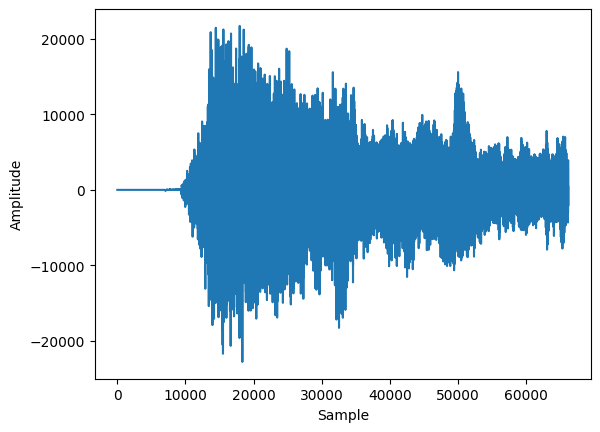

In [5]:
plt.figure
plt.plot(x)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

And we can also plot the magnitude of the frequency domain after performing fft as follows:

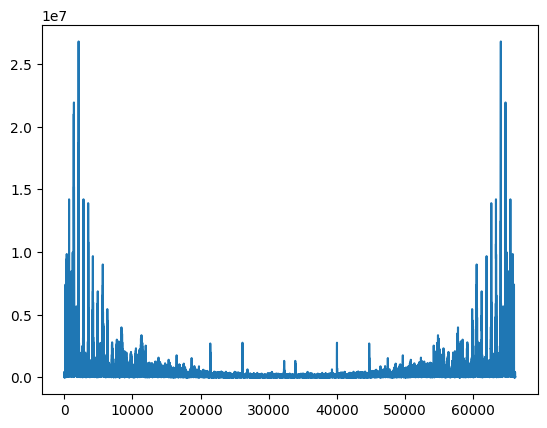

In [6]:
X = fft(x)
plt.plot(np.abs(X))

Performing ifft on the frequency domain gives us back our original time domain signal, as we can see below that the result of ifft exactly matches with the plot of the original time domain signal we plotted earlier.

/usr/local/lib/python3.10/dist-packages/IPython/lib/display.py:159: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


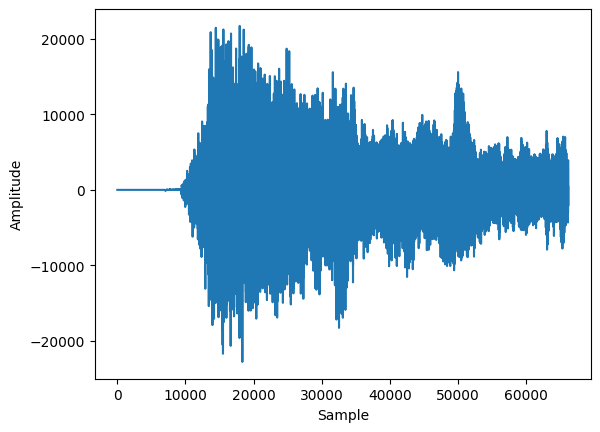

In [7]:
x_new = ifft(X)

Audio(x_new, rate=Fs)
plt.figure
plt.plot(x_new)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

##Task 1
Now write a function that takes an input signal and a noise level, $l$, and noise rate, $r$, as parameters and returns the input signal after corrupting it with noise. Noise level is considered as a fraction of the peak signal value and noise rate is considered as the probability by which a particular sample will be affected by noise. Both noise level and noise rate are in the range of $0-1$.

In [8]:
def addRandomNoise(x, l, r):
  #your code here
    peak_value = np.max(np.abs(x))
    noise = np.random.uniform(-l * peak_value, l * peak_value, size=x.shape)
    noise_mask = np.random.rand(*x.shape) < r
    #print(noise_mask) True false or 0,1 type vale based on the compare
    noisy_signal = x + noise * noise_mask

    return noisy_signal




For the previous audio sample, apply your implemented noise function with a noise level of $0.05$ and a noise rate of 0.5. Plot the noisy audio.

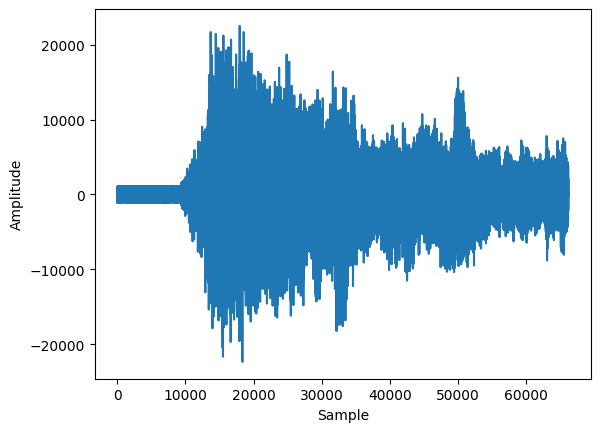

In [9]:
#Your code here
x_noised= addRandomNoise(x,0.05,0.5)
plt.figure
plt.plot(x_noised)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()
Audio(x_noised, rate=Fs)

##Task 2
Write a function named MAF() that takes an input signal $x$ and a filter size $n$ and returns a filtered output signal after convolving the input with an appropriate filter kernel. The function should internally generate the filter kernel based on the size parameter. Note that the averaging mechanism should be symmetric.


In [23]:
def convolve_input_side(x, h):
    M = len(x)
    N = len(h)
    L = M + N - 1
    y = np.zeros(L)
    h_flipped = np.flip(h)
    x_padded = np.pad(x, (N - 1, N - 1), mode='constant')

    for n in range(L):
        for k in range(N):
            if n - k >= 0 and n - k < M:
                y[n] += h_flipped[k] * x_padded[n - k]

    return y

In [26]:
from scipy.signal import convolve
def MAF(x, n):
  #your code here
    kernel = np.ones(n) / n
    kernel = np.concatenate((kernel[::-1], kernel[1:]))
    filtered_signal =convolve_input_side(x, kernel)

    return filtered_signal


Apply the MAF function on the previously corrupted audio and test different filter sizes to find which one produces an output that most closely resembles the original audio. Use subplot to show the output after applying filters of different sizes.

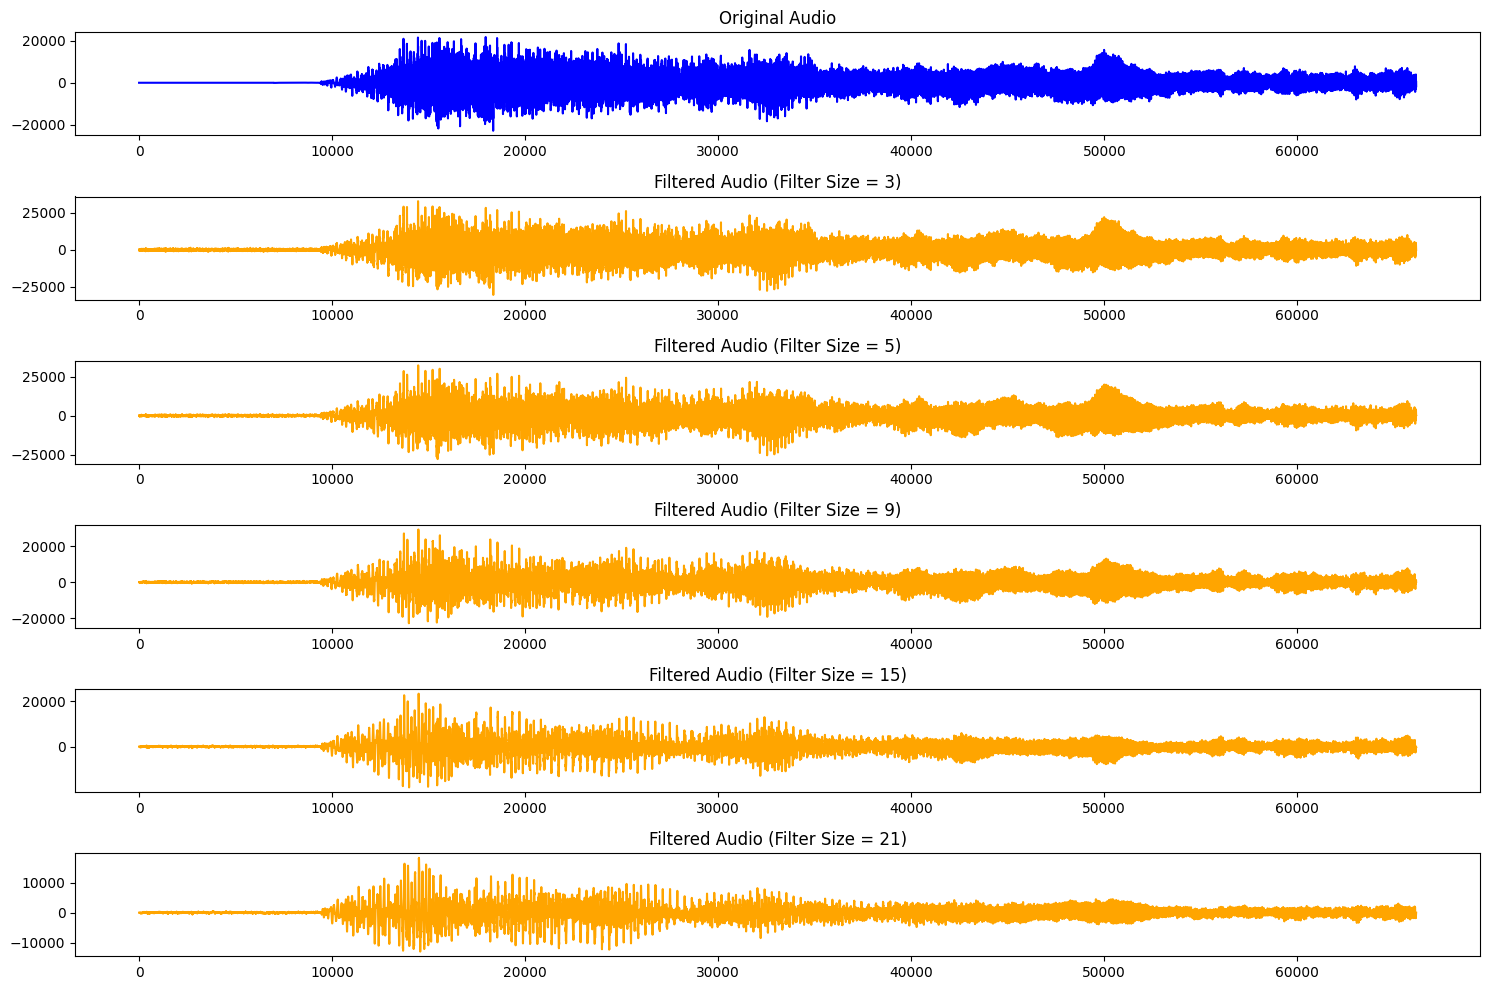

In [27]:
#Your code here
filter_sizes = [3, 5, 9,15,21]

# Create subplots
num_plots = len(filter_sizes) + 1
plt.figure(figsize=(15, 10))

# Plot original audio
plt.subplot(num_plots, 1, 1)
plt.plot(x, color='blue')
plt.title('Original Audio')

for i, n in enumerate(filter_sizes):
    filtered_audio = MAF(x_noised, n)
    plt.subplot(num_plots, 1, i + 2)
    plt.plot(filtered_audio, color='orange')
    plt.title(f'Filtered Audio (Filter Size = {n})')

plt.tight_layout()
plt.show()

Audio(filtered_audio, rate=Fs)

##Task 3
Write another function MAF_optimized() that achieves the same filtering effect without performing convolution.

*Hint: Use Recursion

In [12]:
def MAF_optimized(x, n):
    N = len(X)
    Y = np.zeros(N, dtype=np.float64)

    # Calculate initial accumulator value
    ACC = np.sum(X[:n])
    Y[n // 2] = ACC / n

    # Recursive moving average filter
    for i in range(n // 2 + 1, N - n // 2):
        ACC = ACC + X[i + n // 2] - X[i - n // 2 - 1]
        Y[i] = ACC / n

    return Y

Apply both MAF() and MAF_optimized() and plot the difference in time needed to apply the filter for different sizes ranging from $3$ to $99$ (using odd sizes for symmetric averaging).

<ipython-input-12-afd0eb4ee4b3>:7: ComplexWarning: Casting complex values to real discards the imaginary part
  Y[n // 2] = ACC / n
<ipython-input-12-afd0eb4ee4b3>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  Y[i] = ACC / n


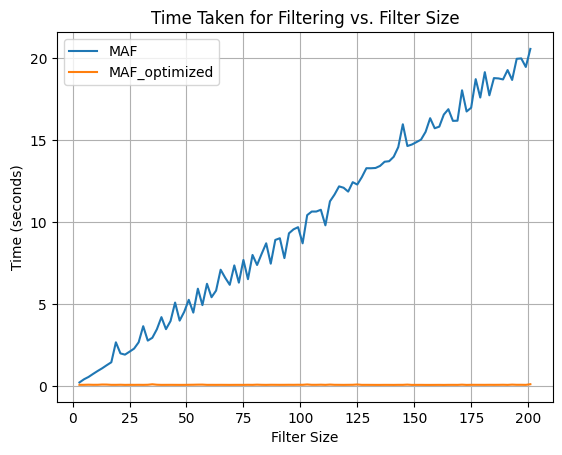

In [28]:
import time
filter_sizes = range(3, 202, 2)

# Measure time for MAF
times_MAF = []
for n in filter_sizes:
    start_time = time.time()
    _ = MAF(x_noised, n)
    end_time = time.time()
    times_MAF.append(end_time - start_time)

# Measure time for MAF_optimized
times_MAF_optimized = []
for n in filter_sizes:
    start_time = time.time()
    _ = MAF_optimized(x_noised, n)
    end_time = time.time()
    times_MAF_optimized.append(end_time - start_time)

# Plot the difference in time
plt.plot(filter_sizes, times_MAF, label='MAF')
plt.plot(filter_sizes, times_MAF_optimized, label='MAF_optimized')
plt.xlabel('Filter Size')
plt.ylabel('Time (seconds)')
plt.title('Time Taken for Filtering vs. Filter Size')
plt.legend()
plt.grid(True)
plt.show()

##Task 4
Implement Gaussian filter as a special case of the multiple-pass moving average filter. Use the Gaussian filter on the given audio and plot the result for different sizes using subplot.

<ipython-input-12-afd0eb4ee4b3>:7: ComplexWarning: Casting complex values to real discards the imaginary part
  Y[n // 2] = ACC / n
<ipython-input-12-afd0eb4ee4b3>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  Y[i] = ACC / n


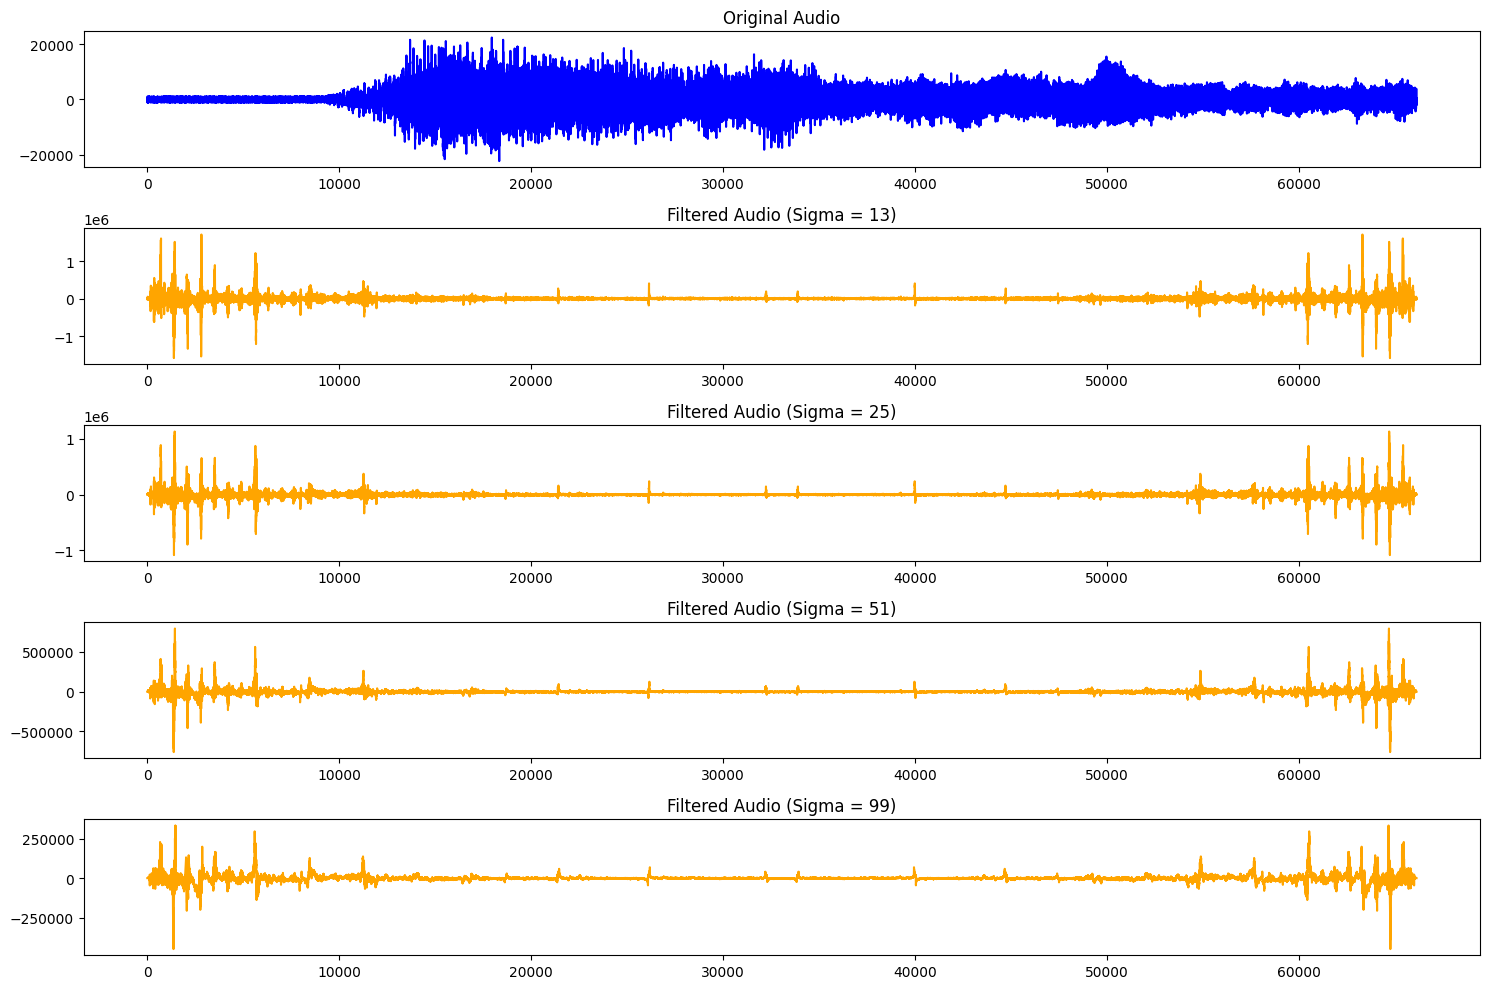

In [22]:
def gaussian_filter(x, n):
    a=MAF_optimized(x,n)
    b=MAF_optimized(a,n)
    c=MAF_optimized(b,n)
    d=MAF_optimized(c,n)
    e=MAF_optimized(d,n)
    return MAF_optimized(e,n)



sigmas = [13,25,51,99]

num_plots = len(sigmas)+1
plt.figure(figsize=(15, 10))

# Plot original audio
plt.subplot(num_plots, 1, 1)
plt.plot(x_noised, color='blue')
plt.title('Original Audio')

# Apply Gaussian filter with different sigmas and plot results
for i, sigma in enumerate(sigmas):
    filtered_audio = gaussian_filter(x_noised, sigma)
    plt.subplot(num_plots, 1, i + 2)
    plt.plot(filtered_audio, color='orange')
    plt.title(f'Filtered Audio (Sigma = {sigma})')

plt.tight_layout()
plt.show()
